In [94]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import time

# Inicialización de parametros

In [73]:
def random_initialization(layers_dims):
    parameters = {}
    L = len(layers_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l-1], layers_dims[l]) * 0.01
        parameters['b' + str(l)] = np.zeros((1, layers_dims[l]))

    return parameters

# Funciones de activación

In [74]:
def relu(x):
    return np.maximum(0, x)

In [75]:
def relu_derivative(x):
  return np.where(x > 0, 1, 0)

In [76]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Forward propagation

In [77]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # Capa 1: Linear -> ReLU
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)

    # Capa 2: Linear -> ReLU
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)

    # Capa 3: Linear -> Softmax
    z3 = np.dot(a2, W3) + b3
    a3 = softmax(z3)

    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    return a3, cache

# Backward Propagation

In [78]:
def backward_propagation(X, y, cache):

    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    m = X.shape[0]

    dz3 = a3 - y
    dW3 = np.dot(a2.T, dz3) / m
    db3 = np.sum(dz3, axis=0, keepdims=True) / m
    
    da2 = np.dot(dz3, W3.T)
    dz2 = da2 * relu_derivative(a2)  
    dW2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0, keepdims=True) / m

    da1 = np.dot(dz2, W2.T)
    dz1 = da1 * relu_derivative(a1)  
    dW1 = np.dot(X.T, dz1) / m
    db1 = np.sum(dz1, axis=0, keepdims=True) / m

    gradients = {'dz1': dz1, 'dA1': da1, 'dW1': dW1, 'db1': db1, 'dz2': dz2, 'dA2': da2, 'dW2': dW2, 'db2': db2, 'dz3': dz3, 'dW3': dW3, 'db3': db3}

    return gradients


# Función de costo

In [79]:
def compute_cost(a3, y_true):
    
    m = y_true.shape[0]  

    cost = -np.sum(y_true * np.log(a3 + 1e-8)) / m  

    return cost

# Optimizadores

In [80]:
class EstocasticOptimizer():
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
    
    def update(self, parameters, grads):
        L = len(parameters) // 2 
    
        for l in range(L):
            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - self.learning_rate * grads["dW" + str(l + 1)]
            parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - self.learning_rate * grads["db" + str(l + 1)]
        return parameters

In [81]:
class AdamOptimizer():
    def __init__(self, parameters, learning_rate):
        self.v = {}
        self.s = {}
        self.learning_rate = learning_rate
        L = len(parameters) // 2

        for l in range(L):
            self.v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
            self.v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

            self.s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l + 1)])
            self.s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l + 1)])

    def update(self, parameters, grads, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
        L = len(parameters) // 2                 
        v_corrected = {}                         
        s_corrected = {}                         

        
        for l in range(L):
            
            self.v["dW" + str(l + 1)] = beta1 * self.v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
            self.v["db" + str(l + 1)] = beta1 * self.v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

            v_corrected["dW" + str(l + 1)] = self.v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
            v_corrected["db" + str(l + 1)] = self.v["db" + str(l + 1)] / (1 - np.power(beta1, t))

            self.s["dW" + str(l + 1)] = beta2 * self.s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
            self.s["db" + str(l + 1)] = beta2 * self.s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)

            s_corrected["dW" + str(l + 1)] = self.s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
            s_corrected["db" + str(l + 1)] = self.s["db" + str(l + 1)] / (1 - np.power(beta2, t))

            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - self.learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(self.s["dW" + str(l + 1)] + epsilon)
            parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - self.learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(self.s["db" + str(l + 1)] + epsilon)

        return parameters

# Modelo

In [89]:
def model(X, Y, layers_dims, learning_rate=0.01, num_epochs=10000, print_cost=True, optimizer_use="Adam"):

    L = len(layers_dims)             
    costs = []                                                                     
    t = 0

    parameters = random_initialization(layers_dims)
    if optimizer_use == "Adam": optimizer=AdamOptimizer(parameters,learning_rate=learning_rate)
    if optimizer_use == "Estocastic": optimizer=EstocasticOptimizer(learning_rate=learning_rate)

    for i in range(num_epochs):

        a3, cache = forward_propagation(X, parameters)

        cost = compute_cost(a3, Y)

        grads = backward_propagation(X, Y, cache)
        
        
        t+=1
        if optimizer_use == "Adam": parameters=optimizer.update(parameters,grads,t,learning_rate)
        if optimizer_use == "Estocastic": parameters=optimizer.update(parameters,grads)
       
        if print_cost and i % 1000 == 0:
            print("Cost after epoch %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
        
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title(f"Optimizador: {optimizer_use}; Learning rate = " + str(learning_rate))
    plt.show()
    
    return parameters

# Predicción

In [83]:
def predict(X, parameters, y_test):

    a3, _ = forward_propagation(X, parameters)
    predictions = np.argmax(a3, axis=1)  
    
    y_test_labels = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test_labels, predictions)

    return predictions, accuracy


In [84]:
iris = load_iris()
X = iris.data  
y = iris.target.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y)  

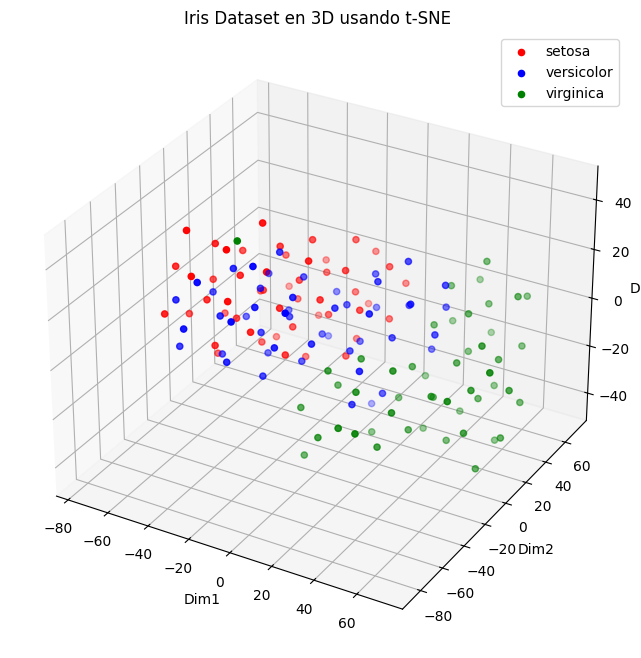

In [85]:
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
X_reduced = tsne.fit_transform(X)

df = pd.DataFrame(X_reduced, columns=['Dim1', 'Dim2', 'Dim3'])
df['target'] = y

colors = ['red', 'blue', 'green']
target_names = iris.target_names

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, target_name in enumerate(target_names):
    ax.scatter(df.loc[df['target'] == i, 'Dim1'],
               df.loc[df['target'] == i, 'Dim2'],
               df.loc[df['target'] == i, 'Dim3'],
               label=target_name, color=colors[i])

ax.set_xlabel('Dim1')
ax.set_ylabel('Dim2')
ax.set_zlabel('Dim3')
ax.set_title('Iris Dataset en 3D usando t-SNE')
ax.legend()
plt.show()

Cost after epoch 0: 1.098602
Cost after epoch 1000: 0.019423
Cost after epoch 2000: 0.007023
Cost after epoch 3000: 0.003981
Cost after epoch 4000: 0.002134
Cost after epoch 5000: 0.001112
Cost after epoch 6000: 0.000576
Cost after epoch 7000: 0.000300
Cost after epoch 8000: 0.000159
Cost after epoch 9000: 0.000085


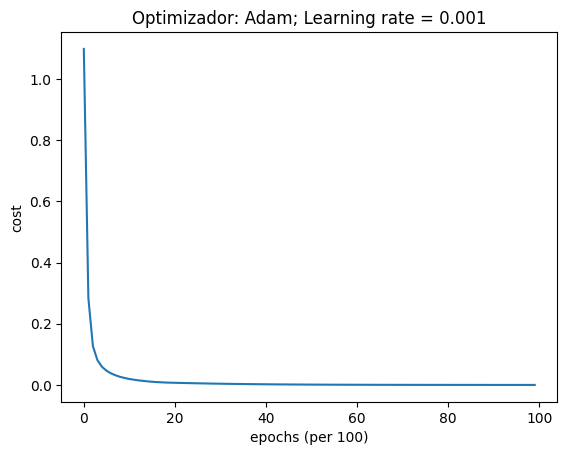

La exactitud es de: 95.238095 %
------------------------

Cost after epoch 0: 1.098611
Cost after epoch 1000: 1.091786
Cost after epoch 2000: 1.091793
Cost after epoch 3000: 1.091794
Cost after epoch 4000: 1.091795
Cost after epoch 5000: 1.091792
Cost after epoch 6000: 1.091802
Cost after epoch 7000: 1.091789
Cost after epoch 8000: 1.091808
Cost after epoch 9000: 1.091787


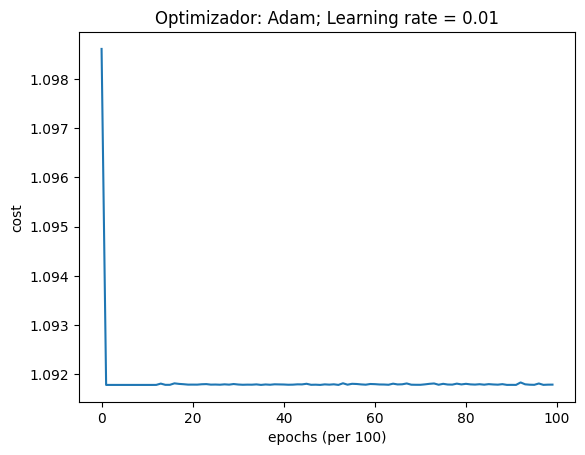

La exactitud es de: 47.619048 %
------------------------

Cost after epoch 0: 1.098606
Cost after epoch 1000: 1.091786
Cost after epoch 2000: 1.093352
Cost after epoch 3000: 1.094633
Cost after epoch 4000: 1.092660
Cost after epoch 5000: 1.091887
Cost after epoch 6000: 1.092355
Cost after epoch 7000: 1.092497
Cost after epoch 8000: 1.091955
Cost after epoch 9000: 1.093284


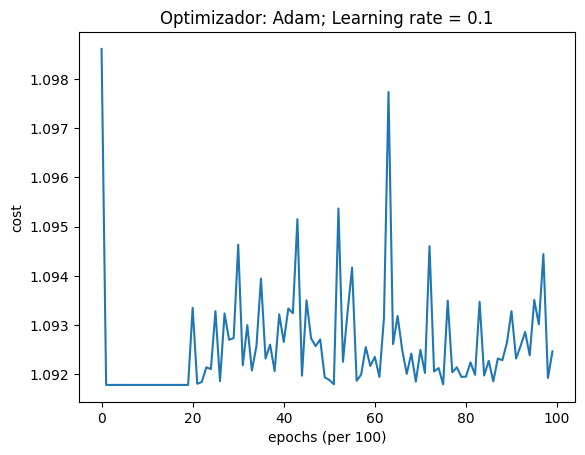

La exactitud es de: 47.619048 %
------------------------

Cost after epoch 0: 1.098612
Cost after epoch 1000: 1.095300
Cost after epoch 2000: 1.093599
Cost after epoch 3000: 1.092723
Cost after epoch 4000: 1.092271
Cost after epoch 5000: 1.092037
Cost after epoch 6000: 1.091916
Cost after epoch 7000: 1.091852
Cost after epoch 8000: 1.091819
Cost after epoch 9000: 1.091801


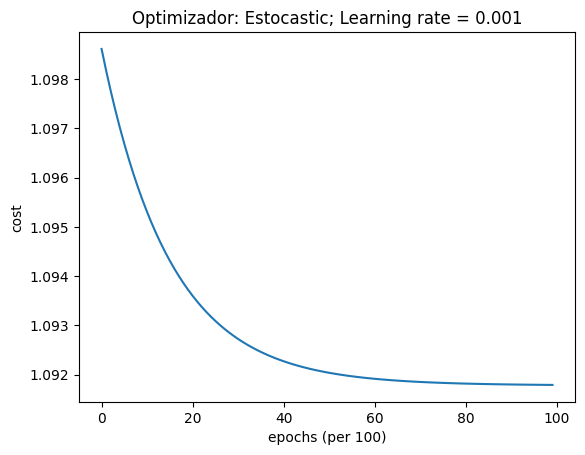

La exactitud es de: 47.619048 %
------------------------

Cost after epoch 0: 1.098616
Cost after epoch 1000: 1.091796
Cost after epoch 2000: 1.091785
Cost after epoch 3000: 1.091784
Cost after epoch 4000: 1.091782
Cost after epoch 5000: 1.091778
Cost after epoch 6000: 1.091770
Cost after epoch 7000: 1.091753
Cost after epoch 8000: 1.091702
Cost after epoch 9000: 1.091464


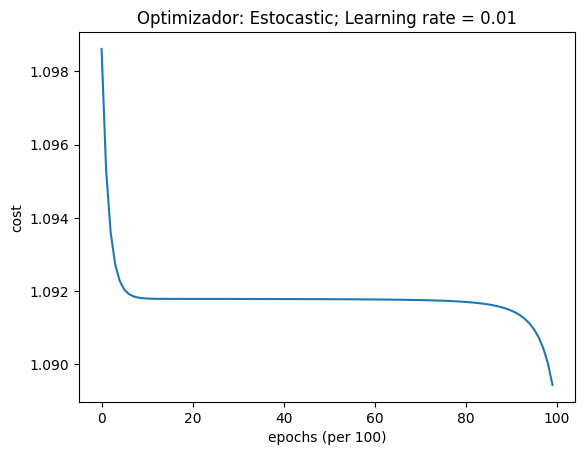

La exactitud es de: 47.619048 %
------------------------

Cost after epoch 0: 1.098611
Cost after epoch 1000: 0.629812
Cost after epoch 2000: 0.019857
Cost after epoch 3000: 0.005294
Cost after epoch 4000: 0.002193
Cost after epoch 5000: 0.001248
Cost after epoch 6000: 0.000829
Cost after epoch 7000: 0.000603
Cost after epoch 8000: 0.000465
Cost after epoch 9000: 0.000374


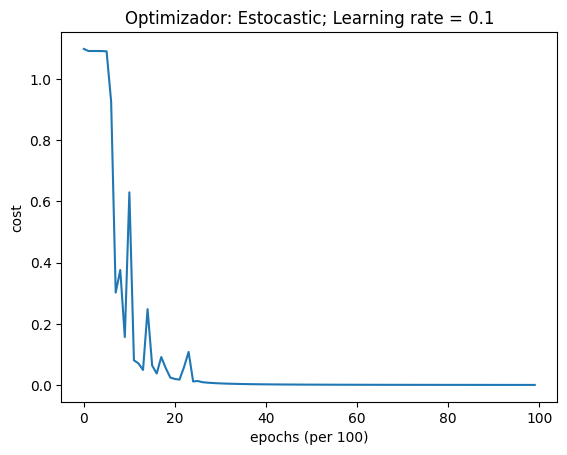

La exactitud es de: 95.238095 %
------------------------



In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=156477)
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=15477)

layers_dims = [X.shape[1], 10, 8, 3]
learning_rates = [0.001, 0.01, 0.1]
optimizers = ['Adam', 'Estocastic']
for optimizer in optimizers:
    for learning_rate in learning_rates:
        parameters = model(X_train_2, y_train_2, layers_dims, optimizer_use=optimizer, learning_rate=learning_rate)
        time.sleep(1)
        predictions, accuracy = predict(X_val, parameters, y_val)
        print(f'La exactitud es de: {accuracy*100:.6f} %')
        print(f'------------------------\n')

Cost after epoch 0: 1.098605
Cost after epoch 1000: 0.057870
Cost after epoch 2000: 0.030722
Cost after epoch 3000: 0.020042
Cost after epoch 4000: 0.013864
Cost after epoch 5000: 0.009755
Cost after epoch 6000: 0.006455
Cost after epoch 7000: 0.004645
Cost after epoch 8000: 0.003396
Cost after epoch 9000: 0.002537


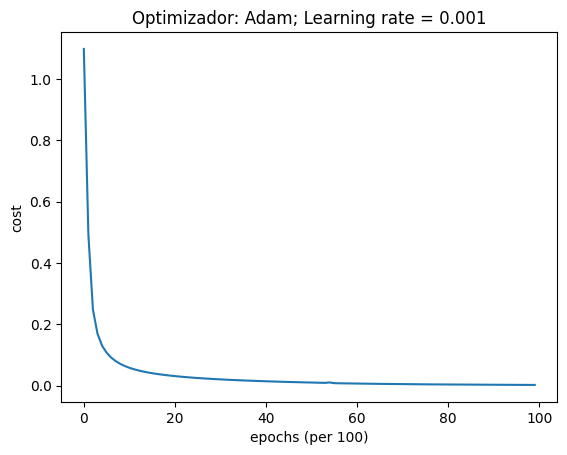

Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


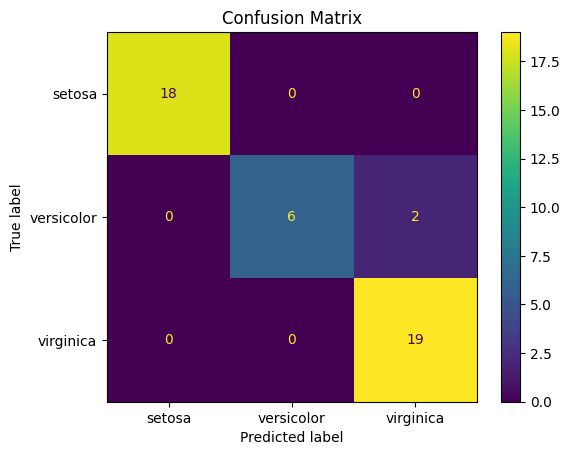

------------------------

Cost after epoch 0: 1.098609
Cost after epoch 1000: 0.148650
Cost after epoch 2000: 0.023294
Cost after epoch 3000: 0.016409
Cost after epoch 4000: 0.014415
Cost after epoch 5000: 0.021393
Cost after epoch 6000: 0.020107
Cost after epoch 7000: 0.019151
Cost after epoch 8000: 0.018359
Cost after epoch 9000: 0.017682


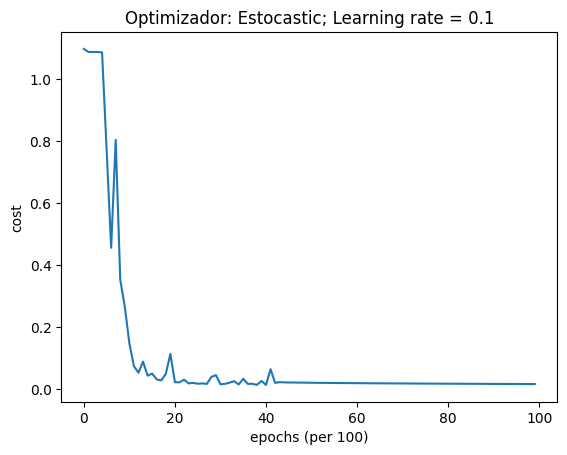

Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


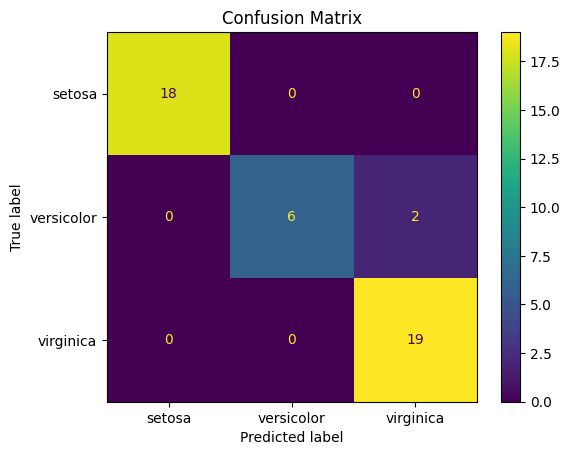

------------------------



In [99]:
lr = [0.001, 0.1]
op = ["Adam", "Estocastic"]

for i in range(len(lr)):
    parameters = model(X_train, y_train, layers_dims, optimizer_use=op[i], learning_rate=lr[i])
    predictions, accuracy = predict(X_test, parameters, y_test)
    print(f'Las predicciones son: {predictions}')
    print(f'La exactitud es de: {accuracy*100:.2f} %')
    y_test_labels = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test_labels, predictions)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()
    print(f'------------------------\n')
    
    